In [1]:
# Importation des bibliothèques nécessaires
import os
import glob
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import Dense, Flatten, Reshape, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import gc  # Garbage Collector

2025-05-04 15:50:41.147157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746373841.350728      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746373841.413100      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Configuration de la précision mixte pour optimiser la mémoire
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Vérification de la disponibilité du GPU
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
def setup_gpu():
    # Vérifier les GPU disponibles
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPU disponibles: {len(gpus)}")
    for gpu in gpus:
        print(f" - {gpu}")
    
    if len(gpus) == 0:
        print("Aucun GPU détecté!")
        return None
    
    # Configurer la croissance de mémoire pour éviter d'allouer toute la mémoire immédiatement
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Memory growth activé pour {gpu}")
        except RuntimeError as e:
            print(f"Erreur lors de la configuration de la mémoire pour {gpu}: {e}")
    
    # Activer la journalisation des opérations de distribution si nécessaire
    # os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
    # tf.debugging.set_log_device_placement(True)
    
    # Créer une stratégie de distribution MirroredStrategy pour utiliser tous les GPU
    strategy = tf.distribute.MirroredStrategy()
    print(f"Nombre de périphériques dans la stratégie: {strategy.num_replicas_in_sync}")
    
    return strategy

In [4]:
strategy = setup_gpu()

GPU disponibles: 2
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
 - PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Memory growth activé pour PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Memory growth activé pour PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Nombre de périphériques dans la stratégie: 2


I0000 00:00:1746373853.825538      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746373853.826189      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

In [6]:
# Définition des chemins et constantes
DATA_DIR = '/kaggle/input/visualization_outputUp_2019_2024/PotEvap'
CHECKPOINT_DIR = '/kaggle/working/PotEvap_checkpoints'
MODEL_SAVE_PATH = os.path.join(CHECKPOINT_DIR, 'PotEvap_model')
SCALER_SAVE_PATH = os.path.join(CHECKPOINT_DIR, 'PotEvap_scaler.pkl')

# Création du répertoire de checkpoint s'il n'existe pas
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Paramètres du modèle
SEQUENCE_LENGTH = 30  # Nombre d'images consécutives à utiliser
PREDICTION_STEPS = 7  # Nombre de jours à prédire
IMG_HEIGHT = 128      # Hauteur redimensionnée (réduite pour économiser la mémoire)
IMG_WIDTH = 256       # Largeur redimensionnée
BATCH_SIZE = 32        # Batch size réduit pour économiser la mémoire
EPOCHS = 50           # Nombre d'époques d'entraînement

In [7]:
def extract_date_from_filename(filename):
    """Extraire la date du nom de fichier (ex: PotEvap_20190101.png)"""
    pattern = r'PotEvap_(\d{8})\.png'
    match = re.search(pattern, os.path.basename(filename))
    if match:
        date_str = match.group(1)
        return datetime.strptime(date_str, '%Y%m%d')
    return None

def optimize_memory():
    """Fonction pour libérer la mémoire"""
    gc.collect()
    tf.keras.backend.clear_session()

In [8]:
def load_and_preprocess_images(data_dir, img_height=128, img_width=256, max_images=None):
    """
    Charger et prétraiter les images avec optimisation de la mémoire
    
    Args:
        data_dir: Répertoire contenant les images
        img_height: Hauteur cible des images redimensionnées
        img_width: Largeur cible des images redimensionnées
        max_images: Nombre maximum d'images à charger (None pour toutes)
        
    Returns:
        X_images: Array numpy des images prétraitées
        dates: Liste des dates correspondantes
    """
    # Récupérer tous les chemins d'images
    image_files = glob.glob(os.path.join(data_dir, 'PotEvap_*.png'))
    print(f"Nombre total de fichiers trouvés: {len(image_files)}")
    
    # Limiter le nombre de fichiers si spécifié
    if max_images is not None:
        image_files = image_files[:max_images]
        print(f"Utilisation des {len(image_files)} premiers fichiers")
    
    # Créer une liste de tuples (chemin_fichier, date)
    file_date_pairs = []
    for img_path in image_files:
        date = extract_date_from_filename(img_path)
        if date:
            file_date_pairs.append((img_path, date))
    
    # Trier par date
    file_date_pairs.sort(key=lambda x: x[1])
    print(f"Dates triées: de {file_date_pairs[0][1]} à {file_date_pairs[-1][1]}")
    
    # Charger et prétraiter les images par lots pour économiser la mémoire
    processed_images = []
    dates = []
    
    # Traitement par lots de 100 images
    batch_size = 100
    total_batches = (len(file_date_pairs) + batch_size - 1) // batch_size
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(file_date_pairs))
        
        print(f"Traitement du lot {batch_idx+1}/{total_batches} ({start_idx}-{end_idx})...")
        
        batch_images = []
        batch_dates = []
        
        for img_path, date in file_date_pairs[start_idx:end_idx]:
            try:
                # Charger l'image avec plt.imread (optimisé pour PNG)
                img = plt.imread(img_path)
                
                # Convertir en niveaux de gris si nécessaire
                if len(img.shape) > 2 and img.shape[2] > 1:
                    img = np.mean(img, axis=2)
                
                # Redimensionner l'image (utiliser une taille plus petite économise la mémoire)
                img = tf.image.resize(img[:,:,np.newaxis], [img_height, img_width]).numpy()
                
                # Ajouter à notre lot
                batch_images.append(img)
                batch_dates.append(date)
                
            except Exception as e:
                print(f"Erreur de chargement de {img_path}: {e}")
        
        # Ajouter le lot traité à nos listes principales
        processed_images.extend(batch_images)
        dates.extend(batch_dates)
        
        # Libérer la mémoire
        gc.collect()
    
    # Convertir en array numpy
    X = np.array(processed_images)
    
    print(f"Forme finale des données: {X.shape}")
    return X, dates

In [9]:
def date_to_features(date_obj):
    """Convertit une date en caractéristiques temporelles utilisables par le modèle"""
    # Vérifier si l'entrée est déjà un objet datetime
    if isinstance(date_obj, str):
        date = datetime.strptime(date_obj, '%Y-%m-%d')
    else:
        # Si c'est déjà un objet datetime, l'utiliser directement
        date = date_obj
    
    # Extraire les caractéristiques temporelles
    year = date.year
    month = date.month
    day = date.day
    day_of_year = date.timetuple().tm_yday
    
    # Caractéristiques cycliques pour le mois et le jour de l'année
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    day_sin = np.sin(2 * np.pi * day_of_year / 365)
    day_cos = np.cos(2 * np.pi * day_of_year / 365)
    
    return np.array([year, month, day, day_of_year, month_sin, month_cos, day_sin, day_cos])



Chargement et prétraitement des images...
Nombre total de fichiers trouvés: 2191
Utilisation des 730 premiers fichiers
Dates triées: de 2019-01-05 00:00:00 à 2024-12-31 00:00:00
Traitement du lot 1/8 (0-100)...
Traitement du lot 2/8 (100-200)...
Traitement du lot 3/8 (200-300)...
Traitement du lot 4/8 (300-400)...
Traitement du lot 5/8 (400-500)...
Traitement du lot 6/8 (500-600)...
Traitement du lot 7/8 (600-700)...
Traitement du lot 8/8 (700-730)...
Forme finale des données: (730, 128, 256, 1)
Nombre d'images chargées: 730
Forme des images: (730, 128, 256, 1)
Première date: 2019-01-05 00:00:00
Dernière date: 2024-12-31 00:00:00


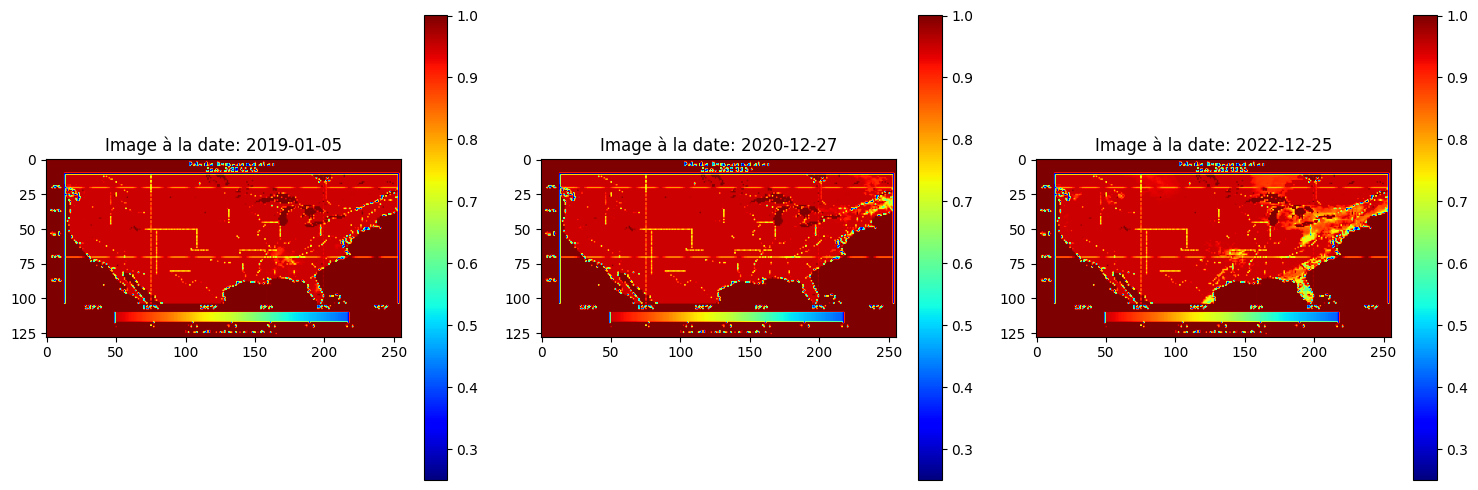

In [10]:
# Exécuter le chargement des données
print("Chargement et prétraitement des images...")
X_images, dates = load_and_preprocess_images(
    DATA_DIR, 
    img_height=IMG_HEIGHT, 
    img_width=IMG_WIDTH,
    max_images=730  # Environ 2 ans de données - ajustez selon vos besoins
)

# Afficher quelques informations
print(f"Nombre d'images chargées: {len(X_images)}")
print(f"Forme des images: {X_images.shape}")
print(f"Première date: {dates[0]}")
print(f"Dernière date: {dates[-1]}")

# Visualiser quelques exemples d'images
plt.figure(figsize=(15, 5))
for i in range(3):  # Afficher 3 images
    idx = i * (len(X_images) // 3)  # Prendre des images réparties uniformément
    plt.subplot(1, 3, i+1)
    plt.imshow(X_images[idx, :, :, 0], cmap='jet')
    plt.title(f"Image à la date: {dates[idx].strftime('%Y-%m-%d')}")
    plt.colorbar()
plt.tight_layout()
plt.show()

# Libérer de la mémoire
optimize_memory()

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_reshaped = X_images.reshape(X_images.shape[0], -1)
X_scaled = scaler.fit_transform(X_reshaped)
X_images_scaled = X_scaled.reshape(X_images.shape)
print(f"Min: {X_images_scaled.min()}, Max: {X_images_scaled.max()}")
del X_reshaped, X_scaled
optimize_memory()

Min: 0.0, Max: 1.0000004768371582


In [12]:
# Générer les features de date
all_date_features = np.array([date_to_features(d) for d in dates])

# Pour chaque date J (sauf la première), on prend l'image J-1 comme entrée et la date J comme feature
X_input_img = X_images_scaled[:-1]           # Images J-1
X_input_date = all_date_features[1:]         # Features date J
Y_output_img = X_images_scaled[1:]           # Images J

print(f"Shapes: X_img: {X_input_img.shape}, X_date: {X_input_date.shape}, Y: {Y_output_img.shape}")

Shapes: X_img: (729, 128, 256, 1), X_date: (729, 8), Y: (729, 128, 256, 1)


In [13]:
from sklearn.model_selection import train_test_split

X_img_train, X_img_val, X_date_train, X_date_val, y_img_train, y_img_val = train_test_split(
    X_input_img, X_input_date, Y_output_img, test_size=0.2, shuffle=False
)
print(f"Train: {len(y_img_train)}, Val: {len(y_img_val)}")

Train: 583, Val: 146


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,
                                     Dense, Reshape, BatchNormalization, Activation, Multiply)
def build_unet_with_date(img_height=128, img_width=256, date_features_size=8, start_filters=8):
    input_image = Input(shape=(img_height, img_width, 1), name='input_image_prev_day')
    input_date = Input(shape=(date_features_size,), name='input_date_target_day')

    # Traitement des features de date
    date_f = Dense(64, activation='relu')(input_date)
    date_f = BatchNormalization()(date_f)
    date_f = Dense(128, activation='relu')(date_f)
    date_f = BatchNormalization()(date_f)
    bottleneck_h, bottleneck_w = img_height // 8, img_width // 8
    bottleneck_filters = start_filters * 4
    date_f = Dense(bottleneck_h * bottleneck_w * bottleneck_filters, activation='relu')(date_f)
    date_f = BatchNormalization()(date_f)
    date_f_reshaped = Reshape((bottleneck_h, bottleneck_w, bottleneck_filters))(date_f)

    # Encodeur
    conv1 = Conv2D(start_filters, (3, 3), padding='same', activation='relu')(input_image)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(start_filters * 2, (3, 3), padding='same', activation='relu')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(start_filters * 4, (3, 3), padding='same', activation='relu')(pool2)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    bottleneck = Multiply()([pool3, date_f_reshaped])

    # Décodeur
    up2 = UpSampling2D(size=(2, 2))(bottleneck)
    up2 = concatenate([up2, conv3], axis=-1)
    conv_up2 = Conv2D(start_filters * 4, (3, 3), padding='same', activation='relu')(up2)
    conv_up2 = BatchNormalization()(conv_up2)

    up1 = UpSampling2D(size=(2, 2))(conv_up2)
    up1 = concatenate([up1, conv2], axis=-1)
    conv_up1 = Conv2D(start_filters * 2, (3, 3), padding='same', activation='relu')(up1)
    conv_up1 = BatchNormalization()(conv_up1)

    up0 = UpSampling2D(size=(2, 2))(conv_up1)
    up0 = concatenate([up0, conv1], axis=-1)
    conv_up0 = Conv2D(start_filters, (3, 3), padding='same', activation='relu')(up0)
    conv_up0 = BatchNormalization()(conv_up0)

    output_image = Conv2D(1, (1, 1), activation='sigmoid', name='output_image_target_day')(conv_up0)
    model = Model(inputs=[input_image, input_date], outputs=output_image)
    return model

In [15]:
with strategy.scope():
    model = build_unet_with_date(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, date_features_size=X_date_train.shape[1], start_filters=8)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='mae',
                  metrics=['mae', 'mse'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image_prev_day      │ (None, 128, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 256, 8)    │             80 │ input_image_prev_day[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 256, 8)    │             32 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_date_target_day     │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 128, 8)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │            576 │ input_date_target_day… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 128, 16)    │          1,168 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64)             │            256 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 128, 16)    │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │          8,320 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 64, 16)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128)            │            512 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 64, 32)     │          4,640 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 16384)          │      2,113,536 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 32, 64, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 2,222,209 (8.48 MB)

 Trainable params: 2,188,833 (8.35 MB)

 Non-trainable params: 33,376 (130.38 KB)

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
callbacks_list = [early_stopping, reduce_lr]

history = model.fit(
    [X_img_train, X_date_train], y_img_train,
    validation_data=([X_img_val, X_date_val], y_img_val),
    epochs=50,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/50


I0000 00:00:1746373958.702141      92 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746373959.349651      91 cuda_dnn.cc:529] Loaded cuDNN version 90300


37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - loss: 0.3492 - mae: 0.3492 - mse: 0.1842 - val_loss: 0.4783 - val_mae: 0.4783 - val_mse: 0.2411 - learning_rate: 1.0000e-04
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1695 - mae: 0.1695 - mse: 0.0781 - val_loss: 0.4256 - val_mae: 0.4256 - val_mse: 0.2140 - learning_rate: 1.0000e-04
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1391 - mae: 0.1391 - mse: 0.0677 - val_loss: 0.3750 - val_mae: 0.3750 - val_mse: 0.1914 - learning_rate: 1.0000e-04
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1292 - mae: 0.1292 - mse: 0.0689 - val_loss: 0.3341 - val_mae: 0.3341 - val_mse: 0.1766 - learning_rate: 1.0000e-04
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1219 - mae: 0.1219 - mse: 0.0673 - val_loss: 0.2958 - val_mae: 0.2958 - val_mse: 0.1587 - learning_rate: 1.0000e-04
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1018 - mae: 0.1018 - mse: 0.0526 - val_loss: 0.2705 - val_mae: 

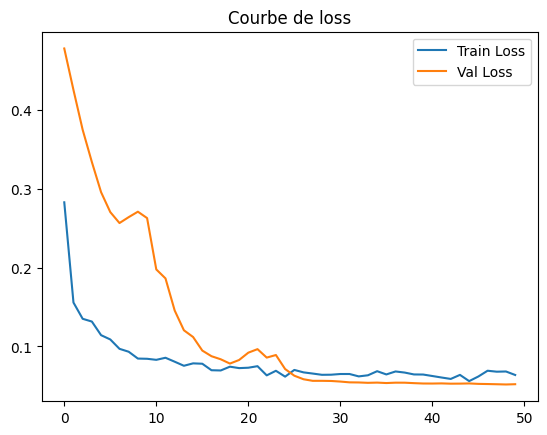

In [17]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Courbe de loss')
plt.show()

In [18]:
print("Nombre total de dates :", len(dates))
print("Premières dates :", dates[:10])
print("Dernières dates :", dates[-10:])

Nombre total de dates : 730
Premières dates : [datetime.datetime(2019, 1, 5, 0, 0), datetime.datetime(2019, 1, 22, 0, 0), datetime.datetime(2019, 1, 24, 0, 0), datetime.datetime(2019, 1, 26, 0, 0), datetime.datetime(2019, 1, 27, 0, 0), datetime.datetime(2019, 1, 29, 0, 0), datetime.datetime(2019, 1, 31, 0, 0), datetime.datetime(2019, 2, 1, 0, 0), datetime.datetime(2019, 2, 8, 0, 0), datetime.datetime(2019, 2, 9, 0, 0)]
Dernières dates : [datetime.datetime(2024, 12, 22, 0, 0), datetime.datetime(2024, 12, 23, 0, 0), datetime.datetime(2024, 12, 24, 0, 0), datetime.datetime(2024, 12, 25, 0, 0), datetime.datetime(2024, 12, 26, 0, 0), datetime.datetime(2024, 12, 27, 0, 0), datetime.datetime(2024, 12, 28, 0, 0), datetime.datetime(2024, 12, 29, 0, 0), datetime.datetime(2024, 12, 30, 0, 0), datetime.datetime(2024, 12, 31, 0, 0)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


W0000 00:00:1746374052.059261      31 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 1 } dim { size: 128 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 1 } dim { size: 8 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multipr

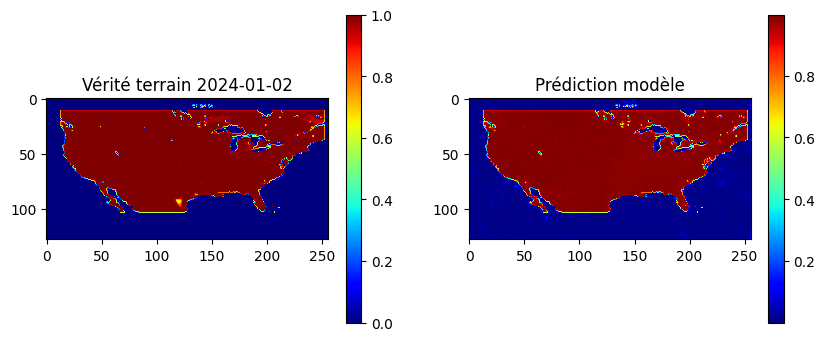

Date 2019-01-10 00:00:00 non trouvée dans les données.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


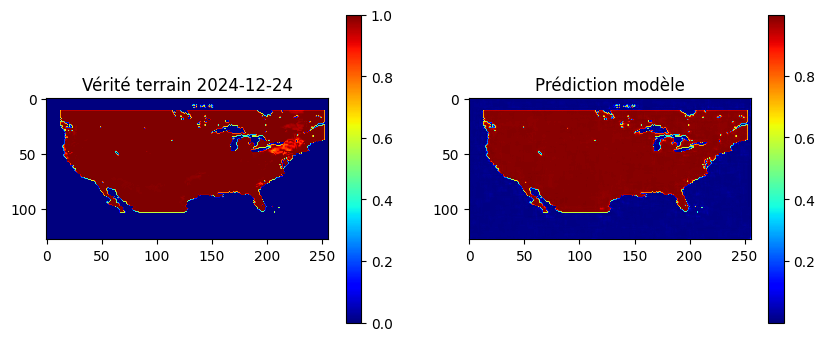

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


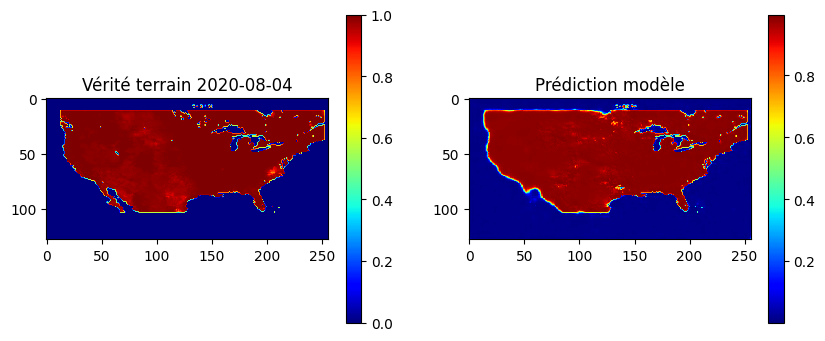

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


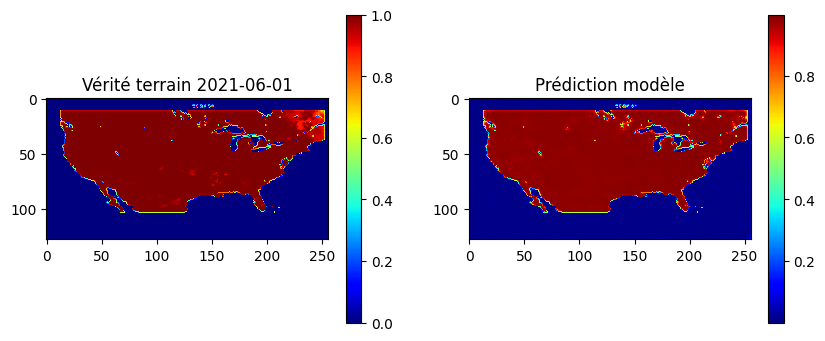

In [19]:
dates_test = [datetime(2024, 1, 2), datetime(2019, 1, 10), datetime(2024, 12, 24),datetime(2020,8,4),datetime(2021, 6, 1)]  # Adapter à tes besoins

for date_cible in dates_test:
    if date_cible not in dates:
        print(f"Date {date_cible} non trouvée dans les données.")
        continue
    idx = dates.index(date_cible)
    img_jmoins1 = X_images_scaled[idx-1][np.newaxis, ...]
    date_features = date_to_features(date_cible)[np.newaxis, ...]
    prediction = model.predict([img_jmoins1, date_features])
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title(f"Vérité terrain {date_cible.date()}")
    plt.imshow(X_images_scaled[idx].squeeze(), cmap='jet')
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.title("Prédiction modèle")
    plt.imshow(prediction.squeeze(), cmap='jet')
    plt.colorbar()
    plt.show()

In [20]:
def get_prediction_at_point(model, date_cible, lon, lat, dates, X_images_scaled, scaler, date_to_features, 
                           lon_min=-125, lon_max=-66.5, lat_min=24, lat_max=50, 
                           img_height=128, img_width=256):

    """
    Retourne la valeur prédite (et réelle si dispo) à une date et un point (lon, lat).
    - model : modèle entraîné
    - date_cible : datetime de la date cible
    - lon, lat : coordonnées du point
    - dates : liste des dates du dataset
    - X_images_scaled : images normalisées
    - scaler : scaler utilisé pour la normalisation
    - date_to_features : fonction pour transformer la date en features
    - lon_min, lon_max, lat_min, lat_max : bornes géographiques de la grille
    - img_height, img_width : dimensions des images
    """
    
    if date_cible not in dates:
        print(f"Date {date_cible} not found in data.")
        return None

    idx = dates.index(date_cible)
    if idx == 0:
        print("No J-1 image available for the first date.")
        return None

    x = int((lon - lon_min) / (lon_max - lon_min) * (img_width - 1))
    y = int((lat_max - lat) / (lat_max - lat_min) * (img_height - 1))
    x = np.clip(x, 0, img_width-1)
    y = np.clip(y, 0, img_height-1)

    img_jmoins1 = X_images_scaled[idx-1][np.newaxis, ...]
    date_features = date_to_features(date_cible)[np.newaxis, ...]
    pred_img = model.predict([img_jmoins1, date_features])
    pred_norm = pred_img[0, y, x, 0]

    # Prepare a dummy flattened image for inverse_transform
    dummy = np.zeros((1, img_height * img_width))
    dummy[0, y * img_width + x] = pred_norm
    pred_denorm_full = scaler.inverse_transform(dummy)
    pred_denorm = pred_denorm_full[0, y * img_width + x]

    # Same for true value
    true_norm = X_images_scaled[idx, y, x, 0]
    dummy_true = np.zeros((1, img_height * img_width))
    dummy_true[0, y * img_width + x] = true_norm
    true_denorm_full = scaler.inverse_transform(dummy_true)
    true_denorm = true_denorm_full[0, y * img_width + x]

    print(f"For date {date_cible.date()} and point (lon={lon}, lat={lat}):")
    print(f" - Model prediction (normalized): {pred_norm:.3f}")
    print(f" - Model prediction (denormalized): {pred_denorm:.2f}")
    print(f" - True value (normalized): {true_norm:.3f}")
    print(f" - True value (denormalized): {true_denorm:.2f}")
    if abs(pred_denorm - true_denorm) < 2:
        print("The model prediction is very close to the true value.")
    else:
        print("The model prediction differs significantly from the true value.")
    return pred_denorm, true_denorm

In [21]:
# Exemples de tests
tests = [
    {"date": datetime(2024, 12, 24), "lon": -100, "lat": 40},
    {"date": datetime(2024, 12, 24), "lon": -80, "lat": 30},
    {"date": datetime(2019,1,10), "lon": -120, "lat": 35},
    {"date": datetime(2019,1,10), "lon": -90, "lat": 45},
]

for test in tests:
    get_prediction_at_point(
        model, test["date"], test["lon"], test["lat"],
        dates, X_images_scaled, scaler, date_to_features
    )
    print("-" * 40)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
For date 2024-12-24 and point (lon=-100, lat=40):
 - Model prediction (normalized): 0.989
 - Model prediction (denormalized): 0.94
 - True value (normalized): 1.000
 - True value (denormalized): 0.95
The model prediction is very close to the true value.
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
For date 2024-12-24 and point (lon=-80, lat=30):
 - Model prediction (normalized): 0.302
 - Model prediction (denormalized): 1.30
 - True value (normalized): 0.000
 - True value (denormalized): 1.00
The model prediction is very close to the true value.
----------------------------------------
Date 2019-01-10 00:00:00 not found in data.
----------------------------------------
Date 2019-01-10 00:00:00 not found in data.
----------------------------------------


In [22]:
# Sauvegarder le modèle complet (architecture + poids + optimizer)
model.save("modele_unet_PotEvap.h5")
print("Modèle sauvegardé sous le nom modele_unet_PotEvap.h5")

Modèle sauvegardé sous le nom modele_unet_PotEvap.h5


In [23]:
from tensorflow.keras.models import load_model

# Load the model without compiling
model1 = load_model("modele_unet_PotEvap.h5", compile=False)

# Compile manually
model1.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])

In [24]:
def predict_value_for_web(model, date_cible, lon, lat, dates, X_images_scaled, date_to_features, 
                          lon_min=-125, lon_max=-66.5, lat_min=24, lat_max=50, 
                          img_height=128, img_width=256):
    """
    Prédit la valeur normalisée à une date et un point (lon, lat).
    Retourne uniquement la prédiction (entre 0 et 1).
    """
    if date_cible not in dates:
        return None  # Ou lève une exception selon ton choix

    idx = dates.index(date_cible)
    if idx == 0:
        return None  # Pas d'image J-1 disponible

    # Conversion coordonnées -> indices image
    x = int((lon - lon_min) / (lon_max - lon_min) * (img_width - 1))
    y = int((lat_max - lat) / (lat_max - lat_min) * (img_height - 1))
    x = max(0, min(x, img_width-1))
    y = max(0, min(y, img_height-1))

    img_jmoins1 = X_images_scaled[idx-1][np.newaxis, ...]
    date_features = date_to_features(date_cible)[np.newaxis, ...]
    pred_img = model.predict([img_jmoins1, date_features])
    pred_norm = float(pred_img[0, y, x, 0])  # Conversion en float natif pour compatibilité API

    return pred_norm

In [25]:
# Exemple de test pour la fonction predict_value_for_web

from datetime import datetime

# Exemple d'entrée
date_test = datetime(2024, 1, 2)
longitude_test = -100.0
latitude_test = 40.0

# Appel de la fonction
valeur_predite = predict_value_for_web(
    model1,
    date_test,
    longitude_test,
    latitude_test,
    dates,
    X_images_scaled,
    date_to_features
)

if valeur_predite is not None:
    print(f"Valeur prédite (normalisée entre 0 et 1) pour la date {date_test.date()} et le point (lon={longitude_test}, lat={latitude_test}) : {valeur_predite:.3f}")
else:
    print("Aucune prédiction possible pour cette date ou ce point (vérifie la présence de la date et que ce n'est pas la première du dataset).")

I0000 00:00:1746374055.581079      91 service.cc:148] XLA service 0x32ee0b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746374055.581978      91 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746374055.582003      91 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Valeur prédite (normalisée entre 0 et 1) pour la date 2024-01-02 et le point (lon=-100.0, lat=40.0) : 0.991


I0000 00:00:1746374056.585884      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
